# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [3]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, device=device)

        
        self.connected_1 = torch.nn.Linear(in_features=400, out_features=120, device=device)
        self.connected_2 = torch.nn.Linear(in_features=120, out_features=84, device=device)
        self.connected_3 = torch.nn.Linear(in_features=84, out_features=10, device=device)

    def forward(self, x):
        

        x = self.conv_1(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = self.conv_2(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = x.view(x.shape[0], -1)                

        x = self.connected_1(x)
        x = torch.nn.functional.relu(x)

        x = self.connected_2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.connected_3(x)

        x = F.log_softmax(x, dim=1)
        return x


### Define cost function

In [6]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [7]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(), lr, momentum = momentum, weight_decay=wd)
  return optimizer

### Train and test functions

In [8]:
def test(net, data_loader, cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [9]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [10]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(
        net,
        batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.00001,
         momentum=0.9,
         epochs=50):

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [11]:
net = LeNet()

In [12]:
main(net=net)

Before training:
	 Training loss 0.01807, Training accuracy 9.67
	 Validation loss 0.00907, Validation accuracy 9.80
	 Test loss 0.00923, Test accuracy 9.82
-----------------------------------------------------


KeyboardInterrupt: 

Check which MNIST digit is most frequently confused with which other digit (e.g. plot a confusion matrix). Can you explain why?



In [25]:
def confusionMatrix(net, get_data, args):
    
    y_pred = np.array([])
    labels = np.array([])
    _, _, test_loader = get_data(**args)
    net.eval()

    for data, target in test_loader:

        data = data.to(device)

        pred = torch.argmax(net(data), dim=1)

        y_pred = np.concatenate((y_pred, pred.detach().cpu().numpy()))
        labels = np.concatenate((labels, target.detach().cpu().numpy()))


    cm = confusion_matrix(labels, y_pred)
    ConfusionMatrixDisplay(cm).plot()

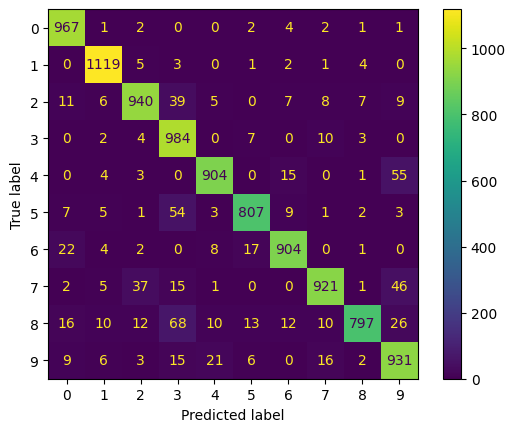

In [26]:
confusionMatrix(net, get_data, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

The LeNet5 architecture can also be implemented using the sequential API ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

## Experiments

* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.


### Early Stopping implementation:

In [27]:
def mainEarlyStopping(
        net,
        batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.00001,
         momentum=0.9,
         epochs=50,
         patience = 5):

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)
  best_val_loss = float('inf')
  earlyStoppingCounter = 0
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      earlyStoppingCounter = 0
    else :
      earlyStoppingCounter +=1
    
    if earlyStoppingCounter >= patience:
      break
        
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [28]:
net = LeNet()

In [29]:
mainEarlyStopping(net = net)

Before training:
	 Training loss 0.01805, Training accuracy 10.48
	 Validation loss 0.00907, Validation accuracy 10.41
	 Test loss 0.00922, Test accuracy 10.28
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00926, Training accuracy 59.45
	 Validation loss 0.00089, Validation accuracy 92.84
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00125, Training accuracy 95.03
	 Validation loss 0.00047, Validation accuracy 96.17
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00078, Training accuracy 96.90
	 Validation loss 0.00039, Validation accuracy 96.78
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00058, Training accuracy 97.71
	 Validation loss 0.00033, Validation accuracy 97.45
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00047, Training accuracy 98.12
	 Validation loss 0.00026, Validation accuracy 97.88
---------------

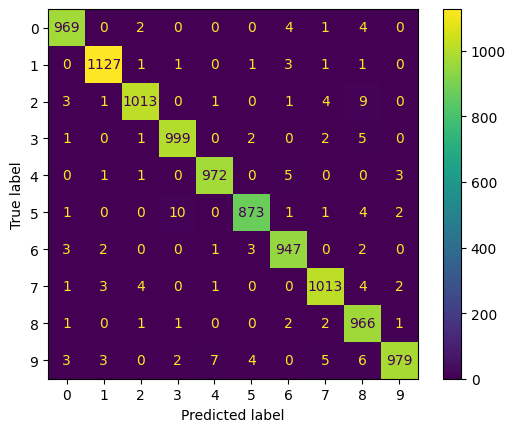

In [30]:
confusionMatrix(net, get_data, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

### Training LeNet5 on Cifar Dataset

In [31]:
def get_data_cifar10(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNetCIFAR(torch.nn.Module):
    
    def __init__(self):
        super(LeNetCIFAR, self).__init__()

        
        self.conv_1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, device=device)

        
        self.connected_1 = torch.nn.Linear(in_features=400, out_features=120, device=device)
        self.connected_2 = torch.nn.Linear(in_features=120, out_features=84, device=device)
        self.connected_3 = torch.nn.Linear(in_features=84, out_features=10, device=device)

    def forward(self, x):

        x = self.conv_1(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = self.conv_2(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = x.view(x.shape[0], -1)                

        x = self.connected_1(x)
        x = torch.nn.functional.relu(x)

        x = self.connected_2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.connected_3(x)

        x = F.log_softmax(x, dim=1)
        return x


In [ ]:
def mainCIFAR(
         net,
         batch_size=128,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.00001,
         momentum=0.9,
         epochs=50,
         patience = 5):

  train_loader, val_loader, test_loader = get_data_cifar10(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)
  best_val_loss = float('inf')
  earlyStoppingCounter = 0
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      earlyStoppingCounter = 0
    else :
      earlyStoppingCounter +=1
    
    if earlyStoppingCounter >= patience:
      break
        
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [34]:
netCifar = LeNetCIFAR()

In [ ]:
mainCIFAR(netCifar)

Before training:
	 Training loss 0.01806, Training accuracy 9.96
	 Validation loss 0.00903, Validation accuracy 10.05
	 Test loss 0.00921, Test accuracy 10.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01794, Training accuracy 14.07
	 Validation loss 0.00859, Validation accuracy 20.04
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01511, Training accuracy 29.37
	 Validation loss 0.00680, Validation accuracy 35.11
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01286, Training accuracy 39.92
	 Validation loss 0.00636, Validation accuracy 41.20
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01185, Training accuracy 45.30
	 Validation loss 0.00570, Validation accuracy 46.57
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01119, Training accuracy 48.39
	 Validation loss 0.00560, Validation accuracy 47.73
----------------

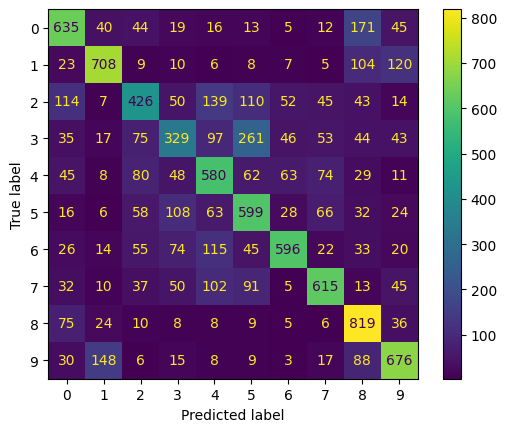

In [ ]:
confusionMatrix(netCifar, get_data_cifar10, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

### Dropout

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNetImproved(torch.nn.Module):
    
    def __init__(self):
        super(LeNetImproved, self).__init__()

        self.droput = torch.nn.Dropout(0.2)
        
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding = 2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, device=device)

        self.connected_1 = torch.nn.Linear(in_features=400, out_features=120, device=device)
        self.connected_2 = torch.nn.Linear(in_features=120, out_features=84, device=device)
        self.connected_3 = torch.nn.Linear(in_features=84, out_features=10, device=device)

    def forward(self, x):
        
        x = torch.clone(x).to(device=device)
        x = self.droput(x)
        x = self.conv_1(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = self.droput(x)
        x = self.conv_2(x)                        
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)  

        x = x.view(x.shape[0], -1)                

        x = self.droput(x)
        x = self.connected_1(x)
        x = torch.nn.functional.relu(x)

        x = self.droput(x)
        x = self.connected_2(x)
        x = torch.nn.functional.relu(x)

        x = self.droput(x)    
        x = self.connected_3(x)

        x = F.log_softmax(x, dim=1)
        return x


In [40]:
netImproved = LeNetImproved()

In [41]:
mainEarlyStopping(net = netImproved)

Before training:
	 Training loss 0.01806, Training accuracy 10.17
	 Validation loss 0.00906, Validation accuracy 10.84
	 Test loss 0.00922, Test accuracy 10.24
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01272, Training accuracy 42.16
	 Validation loss 0.00150, Validation accuracy 89.56
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00314, Training accuracy 87.33
	 Validation loss 0.00068, Validation accuracy 94.89
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00203, Training accuracy 91.94
	 Validation loss 0.00048, Validation accuracy 96.21
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00159, Training accuracy 93.73
	 Validation loss 0.00040, Validation accuracy 96.95
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00141, Training accuracy 94.55
	 Validation loss 0.00035, Validation accuracy 97.27
---------------

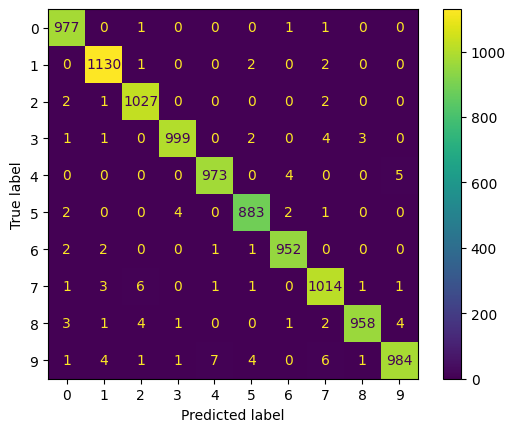

In [42]:
confusionMatrix(netImproved, get_data, {
    "batch_size" : 128,
    "test_batch_size" : 256
})

### Data Augmentation

In [44]:
def get_data_augmented(batch_size, test_batch_size=256, data = 'MNIST'):

  # Prepare data transformations and then combine them sequentially
    transform_augmented = list()
    transform_augmented.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
    transform_augmented.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
    transform_augmented.append(T.RandomRotation(degrees=60))            # Random Rotation
    transform_augmented.append(T.RandomGrayscale(p = 0.1))              # Random Grayscale
    transform_augmented.append(T.RandomAffine(degrees=0, translate=(0.1, 0.1))) # Random Affine Transformation
    transform_augmented = T.Compose(transform_augmented)                          # Composes the above transformations into one.

    transform = list()
    transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
    transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
    transform = T.Compose(transform)                          # Composes the above transformations into one.    

  # Load data
    if data != 'MNIST' and data != 'CIFAR':
        raise Exception("Please Choose either CIFAR or MNIST !")
    
    if data == 'MNIST':
      full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform_augmented, download=True)
      test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

    else :
      full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform_augmented, download=True)
      test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

  # Create train and validation splits
    num_samples = len(full_training_data)
    training_samples = int(num_samples*0.5+1)
    validation_samples = num_samples - training_samples

    training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [47]:
netAugmentedMNIST = LeNetImproved().to(device) 

In [ ]:
def mainAugmented(
        net,
        batch_size=128,
         device='cuda:0' if torch.cuda.is_available else 'cpu',
         learning_rate=0.01,
         weight_decay=0.00001,
         momentum=0.9,
         epochs=50,
         patience = 5):

  train_loader, val_loader, test_loader = get_data_augmented(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)
  best_val_loss = float('inf')
  earlyStoppingCounter = 0
  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      earlyStoppingCounter = 0
    else :
      earlyStoppingCounter +=1
    
    if earlyStoppingCounter >= patience:
      break
        
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

In [49]:
mainAugmented(netAugmentedMNIST)

Before training:
	 Training loss 0.01805, Training accuracy 9.97
	 Validation loss 0.00906, Validation accuracy 9.80
	 Test loss 0.00921, Test accuracy 10.06
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01686, Training accuracy 21.19
	 Validation loss 0.00635, Validation accuracy 47.68
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01007, Training accuracy 55.94
	 Validation loss 0.00281, Validation accuracy 77.49
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00639, Training accuracy 73.46
	 Validation loss 0.00172, Validation accuracy 87.10
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00506, Training accuracy 79.16
	 Validation loss 0.00138, Validation accuracy 89.36
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00427, Training accuracy 82.82
	 Validation loss 0.00107, Validation accuracy 91.90
-----------------

KeyboardInterrupt: 

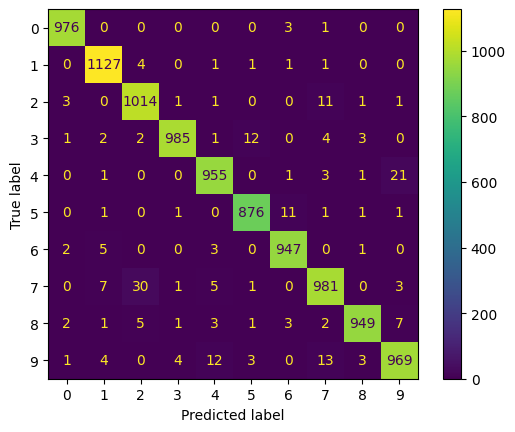

In [62]:
confusionMatrix(netAugmentedMNIST, get_data_augmented, {
    "batch_size" : 128,
    "test_batch_size" : 256,
    "data" : "MNIST"
})

### Resnet18 architecture

In [57]:
resNet = torchvision.models.resnet18().cuda()

In [58]:
mainCIFAR(net = resNet, patience=10)

Before training:
	 Training loss 0.05372, Training accuracy 0.00
	 Validation loss 0.02687, Validation accuracy 0.00
	 Test loss 0.02741, Test accuracy 0.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01410, Training accuracy 39.01
	 Validation loss 0.00613, Validation accuracy 46.53
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01005, Training accuracy 54.43
	 Validation loss 0.00510, Validation accuracy 54.33
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00830, Training accuracy 62.19
	 Validation loss 0.00493, Validation accuracy 56.03
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00704, Training accuracy 68.39
	 Validation loss 0.00496, Validation accuracy 59.19
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00565, Training accuracy 74.62
	 Validation loss 0.00464, Validation accuracy 60.66
------------------

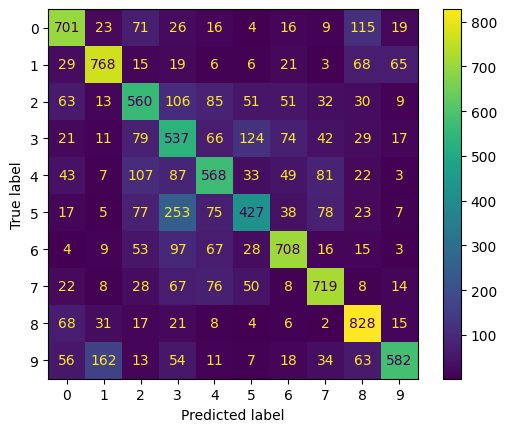

In [59]:
confusionMatrix(resNet, get_data_cifar10, {
    "batch_size" : 128,
    "test_batch_size" : 256
})